In [1]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import gaussian_kde
from scipy import stats as scipystats
from scipy import signal, interpolate
from scipy.interpolate import interp1d
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import reduce

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES
from analysis.processing.epochs import get_epochs
from analysis.plots.utils import get_figure_size, get_extent
from analysis.models.analytics import gaussian_kernel_2D

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [34]:
def get_trajectory_in_arena_rf(h5file):
    with h5py.File(h5file, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])
        arena_trajectory = np.array(f['arena_trajectory'])

    # bring to arena coordinate system
    a_min, a_max = arena_trajectory[:, 2].min(), arena_trajectory[:, 2].max()
    arena_trajectory[:, 2] -= a_min
    try:
        trajectory[:, 2] -= arena_trajectory[:len(trajectory), 2] - ( (a_max - a_min)/2 )
    except:
        print(h5file)
    
    return trajectory

In [33]:
def get_occ_and_speed(sessions_list, bin_size=0.03):
    # get a session for common variables
    animal, session = sessions_list[-1][0], sessions_list[-1][1]
    occupancies = []
    speeds = []

    # use first session to get common params
    trajectory = get_trajectory_in_arena_rf(os.path.join(source, animal, session, 'all.h5'))
    conditions = get_epochs(os.path.join(source, animal, session))

    kernel = gaussian_kernel_2D(0.1)
    
    # let's set the same for all
    #limits = get_figure_size(trajectory[:, 1:3])
    #extent = get_extent(trajectory[:, 1:3])
    #x_min, x_max = trajectory[:, 1].min(), trajectory[:, 1].max()
    #y_min, y_max = trajectory[:, 2].min(), trajectory[:, 2].max()
    
    extent = (-0.4, 0.4, -0.85, 0.85)
    limits = (extent[0] - 0.1, extent[1] + 0.1, extent[2] - 0.1, extent[3] + 0.1)
    x_min, x_max, y_min, y_max = extent
    
    pos_range = np.array([[x_min, x_max], [y_min, y_max]])

    x_range = x_max - x_min
    y_range = y_max - y_min
    y_bin_count = int(np.ceil(y_range / bin_size))
    x_bin_count = int(np.ceil(x_range / bin_size))

    for animal, session, s_type in [s for s in sessions_list]:
        sessionpath = os.path.join(source, animal, session)
        conditions = get_epochs(sessionpath)
        h5file = os.path.join(sessionpath, 'all.h5')

        if not os.path.exists(h5file):
            continue

        trajectory = get_trajectory_in_arena_rf(h5file) 
        sampling_rate = float(round((np.ones(len(trajectory) - 1)/np.diff(trajectory[:, 0])).mean()))

        occup_temp = {}
        speed_temp = {}
        for i, cond in enumerate(conditions):
            with h5py.File(h5file, 'r') as f:
                cond_idxs = np.array(f['%s_idxs' % cond])
                velocity = np.array(f['velocity'])
                velocity = np.append(velocity, [velocity[-1]], axis=0)
                #trajectory = np.array(f['animal_trajectory'])[:, 3]  # t, x, y

            #diffs = np.diff(trajectory[:, :3], axis=0)
            #velocity_Y = diffs[:, 2] / diffs[:, 0]  # dy/dt, only Y-component of the velocity
            #velocity_Y = np.sqrt(np.square(diffs[:, 1]) + np.square(diffs[:, 2])) / diffs[:, 0]  # real velocity
            #velocity_Y = np.append(velocity_Y, 0)
            #weights = velocity_Y[cond_idxs]
            
            pos = trajectory[cond_idxs]
            weights = velocity[cond_idxs][:, 1]  # real velocity
            
            occup, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], range=pos_range)
            speed, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], density=True, weights=weights, range=pos_range)

            occup_temp[cond] = occup / sampling_rate
            #print(sampling_rate, len(pos)/(60.*sampling_rate), len(trajectory)/(60.*sampling_rate), occup_temp[cond].sum())
            #speed_temp[cond] = np.nan_to_num(speed/occup_temp[cond])
            speed_temp[cond] = speed/occup_temp[cond]

        occupancies.append(occup_temp)
        speeds.append(speed_temp)

    # sum across sessions within each condition
    occ_all = {}
    for cond in conditions:
        selection = [occ[cond] for occ in occupancies if cond in occ]
        occ_sum = reduce((lambda x, y: x + y), selection)
        occ_all[cond] = occ_sum/len(selection)

    speed_all = {}
    for cond in conditions:
        colnan = [sp[cond] for sp in speeds if cond in sp]

        result = []
        n, m = np.array(colnan[0]).shape
        for i in range(n):
            for j in range(m):
                result.append(np.nanmean( [x[i, j] for x in colnan] ))

        result = np.array(result)
        result[np.isnan(result)] = 0.
        result = np.reshape(np.array(result), (-1, m))        
        
        #speed_all[cond] = sp_sum/len(selection)        
        speed_all[cond] = result/float(len(colnan))
        
    return conditions, occ_all, speed_all, extent, limits

In [90]:
def plot_arena_stats(maps, extent, limits, titles, hlines=[]):
    fig = figure(figsize=(1.5*len(maps), 3))
    kernel = gaussian_kernel_2D(0.1)

    vmax = np.array([signal.convolve2d(occ, kernel, mode='same').max() for occ in maps.values()]).max()
    collected = []
    for i, cond in enumerate(sorted(maps.keys())):
        occupancy_map = maps[cond]
        occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same') #/kernel.sum()

        ax = fig.add_subplot(1, len(maps.keys()), i+1)
        ax.set_xticks([])
        if i > 0:
            ax.set_yticklabels([])

        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.grid()
        ax.set_title(titles[i], fontsize=14)
        #ax.set_xlabel('X, m', fontsize=14)
        #if i == 0:
        #    ax.set_ylabel('Y, m', fontsize=14)
            
        for hline in hlines:
            ax.axhline(hline, color=COLORS['a'], ls='--')

        #ax.axhspan(-0.3, 0.3, alpha=0.1, color=COLORS['a'])
        
        posPFA = ax.imshow(occupancy_map.T, cmap='jet', origin='lower', extent=extent, vmax=vmax)
        collected.append(occupancy_map.T)

    pos = ax.get_position()
    cax = fig.add_axes([pos.x1 + 0.02, pos.y0 + 0.05, 0.02, ax.get_position().height - 0.1])
    cbar = plt.colorbar(posPFA, cax=cax) # Similar to fig.colorbar(im, cax = cax)
    cbar.set_label('Time, sec/bin', fontsize=14)
    
    return collected

In [72]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
#source = '/storage2/andrey/data/processed'
paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
#paper = '/storage2/andrey/data/projects/24_shift/paper'
animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  # no 002784

In [41]:
names_short = {
    'SHIFT periodic +dark': 'P',
    'SHIFT single +dark': 'S',
    'SHIFT both +dark': 'C',
    'SHIFT visual +dark': 'Vs',
    'SHIFT visual long +dark': 'Vl',
    'GAIN 3 parts 1.2x': 'Gs',
    'GAIN 3 parts 1.4x': 'Gl'
}
early_per = get_sessions_list(source, animals, 'SHIFT periodic')
early_per.remove(['00908', '2019-07-08_17-46-20', 'SHIFT periodic'])  # broken session
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')
single.remove(['005364', '2020-10-23_12-57-03', 'SHIFT single +dark']) # broken session
coherent = get_sessions_list(source, animals, 'SHIFT both +dark')
visual_s = get_sessions_list(source, animals, 'SHIFT visual +dark')  # these are all periodic!
visual_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')  # these could be per / single
gain_12 = get_sessions_list(source, animals, 'GAIN 3 parts 1.2x')
gain_14 = get_sessions_list(source, animals, 'GAIN 3 parts 1.4x')  # 003281, 003282 - remove completely? wrong gain

### single sessions

In [11]:
len(selection)

52

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


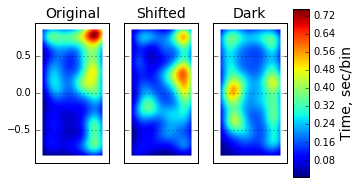

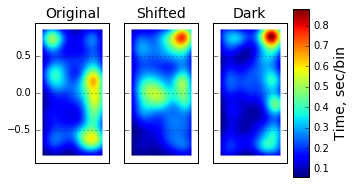

In [79]:
titles = ['Original', 'Shifted', 'Dark']
#titles = ['Original', 'Gain', 'Shifted', 'Dark']

selection = periodic + single
#selection = gain_14
#selection = [x for x in selection if x[0]=='005363']
for i, ss in enumerate(selection[20:22]):
    conditions, occs, speeds, extent, limits = get_occ_and_speed([ss])
    
    # merge dark into one condition
    if 'Ad' in conditions:
        conditions = ('A', 'B', 'D')
        occs['D'] = occs['Ad'] + occs['Bd']
        del occs['Ad']
        del occs['Bd']
    
    maps_plotted = plot_arena_stats(occs, extent, limits, titles)

### Animal averages

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


[['00908', 16], ['00910', 5], ['003281', 17], ['003282', 19], ['003908', 21], ['003909', 2], ['005363', 11], ['005364', 6]]


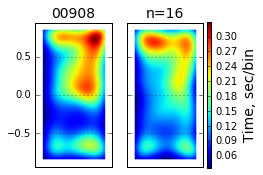

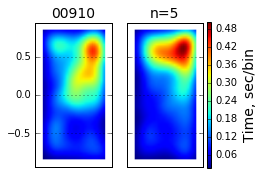

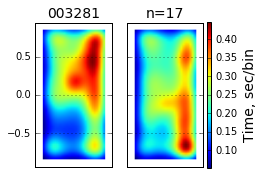

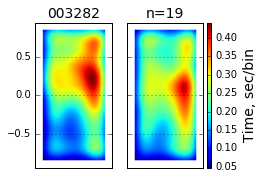

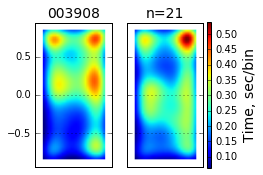

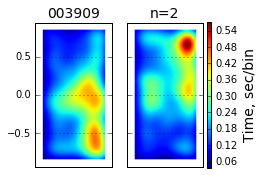

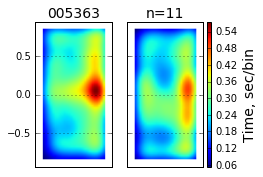

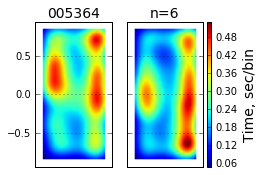

In [96]:
titles = ['Original', 'Shifted', 'Dark']
#titles = ['Original', 'Gain', 'Shifted', 'Dark']

anim_stats = []
selection = early_per
selection = periodic + single + early_per
#selection = visual_l
#selection = gain_14
for i, animal in enumerate(animals):
    ss = [x for x in selection if x[0] == animal]
    if len(ss) == 0:
        continue
    conditions, occs, speeds, extent, limits = get_occ_and_speed(ss)
    
    # merge dark into one condition
    if 'Ad' in conditions:
        conditions = ('A', 'B', 'D')
        occs['D'] = occs['Ad'] + occs['Bd']
        del occs['Ad']
        del occs['Bd']

    # no Dark
    if 'D' in conditions:
        del occs['D']
        
    titles = ["%s" % animal, "n=%s" % len(ss), "", ""]
    maps_plotted = plot_arena_stats(occs, extent, limits, titles)
    anim_stats.append([animal, len(ss)])
    
fig.tight_layout()
filename = "E_4c.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))
print(anim_stats)

### Y-Profiles

In [61]:
occs['A'].shape[0]

27

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


[['00908', 16], ['00910', 5], ['003281', 17], ['003282', 19], ['003908', 21], ['003909', 2], ['005363', 11], ['005364', 6]]


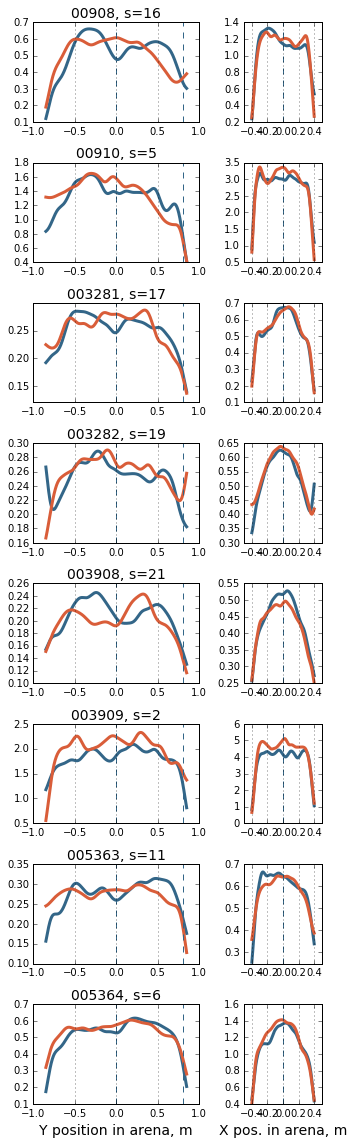

In [101]:
#animals = ['00908', '003281', '003282', '003908', '003909', '005363', '005364']

selection = periodic + single + early_per
#selection = single
#selection = visual_s
#selection = gain_12
#selection = early_per
kernel_1D = signal.gaussian(100, std=15)

labels = ('Original A', 'Shifted B', 'Dark D')
#labels = ('Original A', 'Gain B', 'Shifted C', 'Dark D')
colors = (COLORS['a'], COLORS['b'], COLORS['e'])
#colors = [COLORS['a'], COLORS['c'], COLORS['b'], '#b1b1b1']


fig, axs = plt.subplots(len(animals), 2, gridspec_kw={
    'width_ratios': [1.7, 0.8]})
fig.set_figheight(2*len(animals))
fig.set_figwidth(5)

anim_stats = []
collected = []
for i, animal in enumerate(animals):
    ss = [x for x in selection if x[0] == animal]
    if len(ss) == 0:
        continue
        
    conditions, occs, speeds, extent, limits = get_occ_and_speed(ss)
    anim_stats.append([animal, len(ss)])
    
    occs = speeds  # REMOVE THIS LIKE FOR OCCUPANCIES
    
    # merge dark into one condition for periodic
    conditions = ('A', 'B')
    if 'Ad' in conditions:
        conditions = ('A', 'B', 'D')
        occs['D'] = occs['Ad'] + occs['Bd']
        del occs['Ad']
        del occs['Bd']
        
    lines = []
    for q in range(2):
        ax = axs[i][q]

        for j, cond in enumerate(conditions):
            x_new = np.linspace(extent[2], extent[3], 500)
            x_vals_s = np.linspace(extent[2], extent[3], occs['A'].shape[1])

            if q == 2:  # left
                occs_avg = occs[cond][:14].sum(axis=0)/len(occs[cond][:14])
            elif q == 3: # right
                occs_avg = occs[cond][14:].sum(axis=0)/len(occs[cond][14:])
            elif q == 1:
                occs_avg = occs[cond].sum(axis=1)/occs[cond].shape[0]
                x_new = np.linspace(extent[0], extent[1], 500)
                x_vals_s = np.linspace(extent[0], extent[1], occs['A'].shape[0])
            else:
                occs_avg = occs[cond].sum(axis=0)/len(occs[cond])
            #a_BSpline = interpolate.make_interp_spline(x_vals_s, occs_avg)
            #y_new = a_BSpline(x_new)
            #y_new = np.convolve(y_new, kernel_1D, 'same') / kernel.sum()
            #ax.plot(x_new, y_new, color=colors[j], lw=3, label=labels[j])
            
            f = interp1d(x_vals_s, occs_avg)
            y_new = np.concatenate([np.ones(100)*occs_avg[0], f(x_new), np.ones(100)*occs_avg[-1]])
            y_new = np.convolve(y_new, kernel_1D, 'same') / kernel_1D.sum()
            y_new = y_new[100:-100]
            ax.plot(x_new, y_new, color=colors[j], lw=3, label=labels[j])
            
            if q == 0 and j < 2:
                lines.append([x_new, y_new])

        ax.xaxis.grid()
        ax.axvline(0, color=COLORS['a'], ls='--', label='Virt. walls A')    # virtual walls A
        ax.axvline(0.8, color=COLORS['a'], ls='--')  # virtual walls A
        #ax.axvline(0 - 0.3, color=COLORS['b'], ls='--', label='Virt. walls B')    # virtual walls A
        #ax.axvline(0.8 - 0.3, color=COLORS['b'], ls='--')  # virtual walls A
        #ax.fill_between(x_vals_s[15:41], 0, occ_s_A[15:41], color=COLORS['e'])
        if q == 0:
            #ax.set_ylabel('Occ., sec/bin', fontsize=14)
            ax.set_title('%s, s=%s' % (animal, len(ss)), fontsize=14)
        ax.set_xlim(-1, 1) if q == 0 else ax.set_xlim(-0.5, 0.5)
        if i == len(animals) - 1:
            if q == 0:
                ax.set_xlabel('Y position in arena, m', fontsize=14)
            else:
                ax.set_xlabel('X pos. in arena, m', fontsize=14)
                
    collected.append(lines)
    
fig.tight_layout()
filename = "E_3c.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))
print(anim_stats)

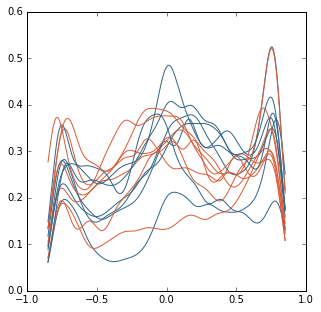

In [51]:
fig = figure(figsize=(5, 5))

ax = fig.add_subplot(111)
for an_lines in collected:
    for i, (x_new, y_new) in enumerate(an_lines):
        color = COLORS['a'] if i == 0 else COLORS['b']
        ax.plot(x_new, y_new, color=color)